In [2]:
from zlg import *
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from functools import partial
from time import time

In [3]:
filepath = 'ex2_data.csv'
x, y = ReadExercise2Data(filepath)
print(x.shape, y.shape)
clf = LogisticRegression()
cv_metric = ['neg_log_loss','accuracy']


(673, 8) (673,)


ZLG

In [18]:
save = False

if save:
    n_sims = 10
    results = []
    start = time()
    for i in range(n_sims):
        print(f'Current Iteration: {i}', end = '\r')
        results.append(SimulateZLG(x,y,i*2024,clone(clf),cv_metric,0.3,1.0,0.01))
    runtime = time()-start
    print(f'Total Runtime for {n_sims} simulations: {runtime//60:02.0f}m:{runtime%60:02.0f}s:{runtime%1*100:02.0f}ms.')

Total Runtime for 10 simulations: 03m:56s:57ms.


In [19]:
for i in range(len(cv_metric)):
    reformated_results = []
    for log in results: # 1 logs for each simulation
        tmp = [] # For storing the results of this simulation
        for generation in log: # Each log has n_iters generations of data saved
            tmp.append(generation[i]) # Store the first log metric for this generation
        reformated_results.append(tmp)
    reformated_results = np.array(reformated_results)

    if save:
        np.save(f'results/ZLG_{cv_metric[i]}.npy',reformated_results)

Expected Risk Minimization (Type 1)

In [5]:
from active_learning import *

In [6]:
save = False

if save:
    n_sims = 10
    start = time()
    with mp.Pool(mp.cpu_count()-1) as p:
        args = [(x.copy(), y.copy(),'ERM',i*2024,clone(clf), cv_metric, y.copy(), None, 0.3, 1.0, CrossValLog) for i in range(n_sims)]
        async_res = p.starmap_async(partial(SimulateAL_MP), args)
        async_res.wait()
        results = async_res.get()
    runtime = time()-start
    print(f'Total Runtime for {n_sims} simulations: {runtime//60:02.0f}m:{runtime%60:02.0f}s:{runtime%1*100:02.0f}ms.')

Total Runtime for 10 simulations: 03m:21s:18ms.


In [7]:
for i in range(len(cv_metric)):
    reformated_results = []
    for log in results: # 1 logs for each simulation
        tmp = [] # For storing the results of this simulation
        for generation in log: # Each log has n_iters generations of data saved
            tmp.append(generation[i]) # Store the first log metric for this generation
        reformated_results.append(tmp)
    reformated_results = np.array(reformated_results)

    if save:
        np.save(f'results/ERM_{cv_metric[i]}.npy',reformated_results)

Visualization

In [20]:
def PlotData(filepaths, labels, full_data_size = None):
    fig, ax = plt.subplots(1)
    mse = []
    errors = []
    for path in filepaths:
        data = np.load(f"results/{path}")
        if "neg" in path.split('_'):
            mse.append(-np.mean(data, axis=0))
        else:
            mse.append(np.mean(data, axis=0))
        errors.append(np.std(data, axis=0))
    
    if full_data_size is None:
        x_pad = 0
    else: 
        x_pad = full_data_size-data.shape[1]
    
    if full_data_size < len(mse):
        raise Exception('full_data_size is shorter than the length of the datasets.')
    
    for data, err, label in zip(mse, errors, labels):
        handle, = ax.plot(range(x_pad, len(data)+x_pad), data, label = label)
        color = handle.get_color()
        ax.errorbar(range(x_pad, len(data)+x_pad), data, err, color = color, linestyle = '', capsize=5, alpha = 0.2)
        ax.legend()

    return fig, ax
    

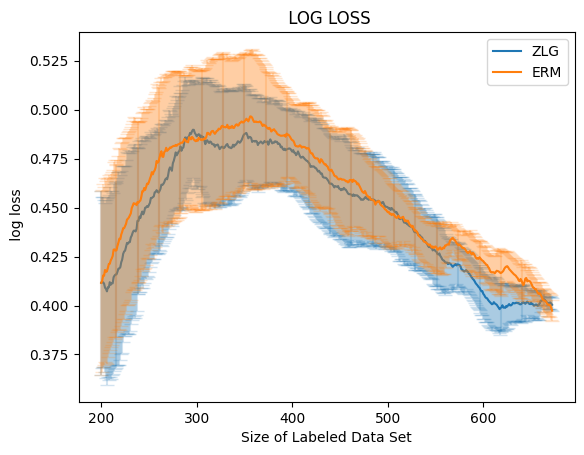

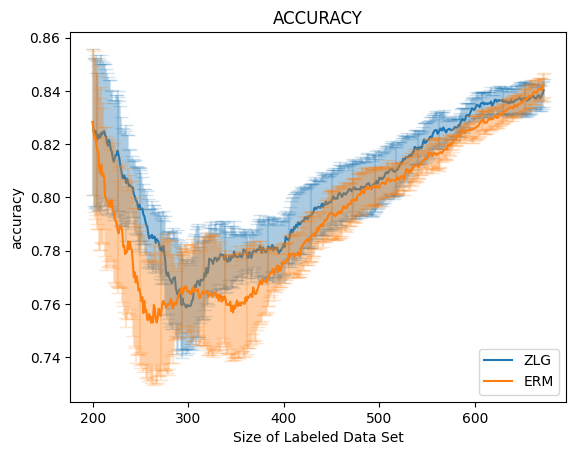

In [21]:
for i in range(len(cv_metric)):
    filepaths = [f'ZLG_{cv_metric[i]}.npy', f'ERM_{cv_metric[i]}.npy']
    labels = 'ZLG', 'ERM'
    fig, ax = PlotData(filepaths, labels, x.shape[0])
    y_lab = cv_metric[i][3:] if cv_metric[i][:3] == "neg" else cv_metric[i]
    y_lab = " ".join(y_lab.split('_'))
    ax.set_title(f'{y_lab.upper()}')
    ax.set_ylabel(f'{y_lab}')
    ax.set_xlabel(f'Size of Labeled Data Set')
    plt.show(fig)